In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip "/content/gdrive/MyDrive/tiny_Data.zip" -d /content/data

In [3]:
# Find the path to the Google Drive directory
import os
path = "/content/data/tiny_Data/"
print(path)
data_dir = path
train_dir = "/content/data/tiny_Data/Data_Small/train/DME"
test_dir = "/content/data/tiny_Data/Data_Small/test/DME"

/content/data/tiny_Data/


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Add, Flatten, Dense, Conv2DTranspose, BatchNormalization, Reshape, PReLU, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import cv2
import PIL
from PIL import Image
from torchvision.transforms import Resize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import glob
from torchvision.transforms import Compose
import matplotlib.pyplot as plt

In [10]:
batch_size = 1

class MyDataset(Dataset):
    def __init__(self, data_dir, transforms=None, high_res_transform=None):
        self.data_dir = data_dir
        self.transforms = transforms
        self.high_res_transform = high_res_transform
        self.img_paths = os.listdir(data_dir)

    def __getitem__(self, item):
        path = os.path.join(self.data_dir, self.img_paths[item])
        img = PIL.Image.open(path).convert('RGB')

        img_low = img
        img_high = img
        if self.transforms is not None:
            img_low = self.transforms(img)
        if self.high_res_transform is not None:
            img_high = self.high_res_transform(img)

        # Transpose axes of image tensor
        img_low = np.transpose(img_low, (1, 2, 0))
        img_high = np.transpose(img_high, (1, 2, 0))

        return (img_low, img_high)


    def __len__(self):
        return len(self.img_paths)

train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor()
])

high_res_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = MyDataset(train_dir, transforms=train_transforms, high_res_transform=high_res_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = MyDataset(test_dir, transforms=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

1510
301


In [11]:
def build_generator(input_shape=(32, 32, 3)):
    inputs = Input(input_shape)
    
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(inputs)
    x = PReLU()(x)
    x1 = x
    
    # Residual blocks
    for _ in range(5):
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = PReLU()(x)
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x1, x])
        x1 = x

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x1, x])

    # Upsampling
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU()(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU()(x)

    x = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    model = Model(inputs=inputs, outputs=x, name='generator')
    return model

def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    layer_filters = [64, 128, 128, 256, 256, 512, 512]
    strides = [2, 1, 2, 1, 2, 1, 2]

    for filters, stride in zip(layer_filters, strides):
        x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='discriminator')
    return model

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_46 (Conv2D)             (None, 32, 32, 64)   15616       ['input_6[0][0]']                
                                                                                                  
 p_re_lu_16 (PReLU)             (None, 32, 32, 64)   65536       ['conv2d_46[0][0]']              
                                                                                                  
 conv2d_47 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_16[0][0]']             
                                                                                          

In [12]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np

# Set the random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Set training parameters
epochs = 75
batch_size = 32

# Build the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Create the SRGAN model
input_shape = (32, 32, 3)
inputs = Input(input_shape)
high_res_fake = generator(inputs)
discriminator.trainable = False
validity = discriminator(high_res_fake)
srgan = Model(inputs, validity)

# Compile the SRGAN model
srgan.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy())

In [ ]:
# Only use this if the model has been trained already
import os

content_dir = '/content'
for file in os.listdir(content_dir):
    if file.endswith('.h5'):
        print(os.path.join(content_dir, file))

from tensorflow.keras.models import load_model

# Load the generator and discriminator models
generator = load_model('generator_epoch_75.h5')
discriminator = load_model('discriminator_epoch_75.h5')

In [8]:
# Define training loop
for epoch in range(epochs):
    num_batches = len(train_dataset) // batch_size
    for i in range(num_batches):
        batch_low_res = []
        batch_high_res = []
        
        for _ in range(batch_size):
            idx = np.random.randint(len(train_dataset))
            low_res_img, high_res_img = train_dataset[idx]
            
            batch_low_res.append(low_res_img.numpy())
            batch_high_res.append(high_res_img.numpy())

        batch_low_res = np.stack(batch_low_res)
        batch_high_res = np.stack(batch_high_res)

        # Train the discriminator
        high_res_fake = generator(batch_low_res)
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(batch_high_res, real_labels)
        d_loss_fake = discriminator.train_on_batch(high_res_fake, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        real_labels = np.ones((batch_size, 1))
        g_loss = srgan.train_on_batch(batch_low_res, real_labels)

        # Print progress
        if i % 50 == 0:
            print(f"Epoch {epoch + 1}, Step {i}, Discriminator Loss: {d_loss[0]}, Discriminator Accuracy: {100 * d_loss[1]}, Generator Loss: {g_loss}")

    # Save model weights every 5 epochs
    if (epoch + 1) % 5 == 0:
        generator.save_weights(f"generator_epoch_{epoch + 1}.h5")
        discriminator.save_weights(f"discriminator_epoch_{epoch + 1}.h5")


Epoch 1, Step 0, Discriminator Loss: 9.202782332897186, Discriminator Accuracy: 28.125, Generator Loss: 0.6540120840072632
Epoch 1, Step 50, Discriminator Loss: 2.735027874223306e-05, Discriminator Accuracy: 100.0, Generator Loss: 0.25826433300971985
Epoch 2, Step 0, Discriminator Loss: 0.000391703171771951, Discriminator Accuracy: 100.0, Generator Loss: 0.0008489791071042418
Epoch 2, Step 50, Discriminator Loss: 4.629447721526958e-05, Discriminator Accuracy: 100.0, Generator Loss: 6.8535141508618835e-06
Epoch 3, Step 0, Discriminator Loss: 4.5115243665350135e-06, Discriminator Accuracy: 100.0, Generator Loss: 1.8076057131111156e-06
Epoch 3, Step 50, Discriminator Loss: 3.0837594329720174e-17, Discriminator Accuracy: 100.0, Generator Loss: 6.783250772668638e-18
Epoch 4, Step 0, Discriminator Loss: 1.9241950053987034e-15, Discriminator Accuracy: 100.0, Generator Loss: 6.936187735284705e-11
Epoch 4, Step 50, Discriminator Loss: 2.0642243746564162e-15, Discriminator Accuracy: 100.0, Gener

1/1 [==============================] - 0s 24ms/step


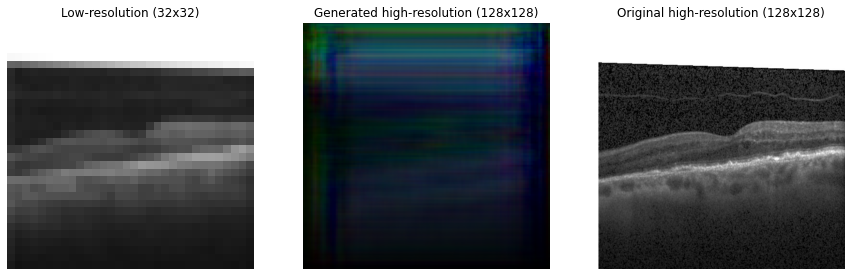

In [20]:
# Load the original high-resolution image
high_res_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

high_res_dataset = MyDataset('/content/data/tiny_Data/Data_Small/train/DME/', transforms=high_res_transforms)
_, high_res_img = high_res_dataset[1]

# Load a 32x32 image from the dataset
low_res_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = MyDataset('/content/data/tiny_Data/Data_Small/train/DME/', transforms=low_res_transforms)
low_res_img, _ = dataset[1]

# Prepare the low-resolution image for inference
low_res_img = low_res_img.unsqueeze(0)  # Add a batch dimension
low_res_img = low_res_img.numpy()  # Convert to numpy array

# Use the generator to upscale the 32x32 image to 128x128
high_res_fake = generator.predict(low_res_img)

# Display the 32x32 image, the upscaled 128x128 image and the original high-resolution image
low_res_img_display = low_res_img[0].transpose(0, 1, 2)
high_res_fake_display = high_res_fake[0].transpose(0, 1, 2)
high_res_img_display = high_res_img.transpose(2, 0, 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(low_res_img_display)
plt.title('Low-resolution (32x32)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(high_res_fake_display)
plt.title('Generated high-resolution (128x128)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(high_res_img_display)
plt.title('Original high-resolution (128x128)')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 51ms/step


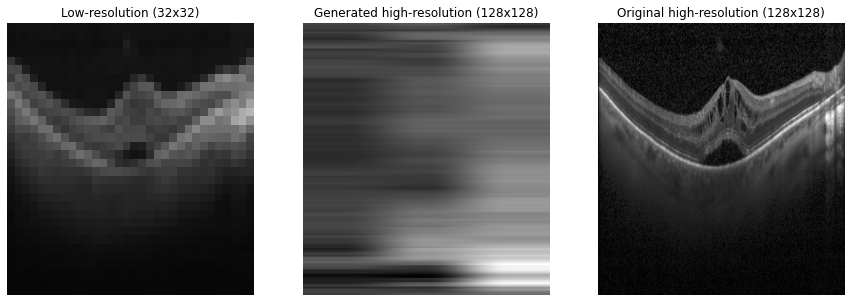

In [32]:
# Load the original high-resolution image
high_res_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

high_res_dataset = MyDataset('/content/data/tiny_Data/Data_Small/train/DME/', transforms=high_res_transforms)
_, high_res_img = high_res_dataset[2]

# Load a 32x32 image from the dataset
low_res_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = MyDataset('/content/data/tiny_Data/Data_Small/train/DME/', transforms=low_res_transforms)
low_res_img, _ = dataset[2]

# Prepare the low-resolution image for inference
low_res_img = low_res_img.unsqueeze(0)  # Add a batch dimension
low_res_img = low_res_img.numpy()  # Convert to numpy array

# Use the generator to upscale the 32x32 image to 128x128
high_res_fake = generator.predict(low_res_img)

# Display the 32x32 image, the upscaled 128x128 image, and the original high-resolution image
low_res_img_display = low_res_img[0].transpose(0, 1, 2)
high_res_fake_display = high_res_fake[0][0]
high_res_img_display = high_res_img.transpose(2, 0, 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(low_res_img_display, cmap='gray', aspect='auto')
plt.title('Low-resolution (32x32)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(high_res_fake_display, cmap='gray', aspect='auto')
plt.title('Generated high-resolution (128x128)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(high_res_img_display, cmap='gray', aspect='auto')
plt.title('Original high-resolution (128x128)')
plt.axis('off')

plt.show()

In [33]:
# Output images generated by SRGAN
import cv2, torch

input_dir = '/content/data/tiny_Data/Data_Small/train/DME/'
output_dir = '/content/data/tiny_Data/Data_Small/train/DME_upscaled/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

low_res_dataset = MyDataset(input_dir, transforms=low_res_transforms)

for idx, (low_res_img, _) in enumerate(low_res_dataset):
    low_res_img = low_res_img.unsqueeze(0).numpy()
    high_res_fake = generator.predict(low_res_img)
    high_res_fake_display = (high_res_fake[0].reshape(128, 128, 3) * 255).clip(0, 255).astype(np.uint8)
    
    output_path = os.path.join(output_dir, f'upscaled_image_{idx}.png')
    cv2.imwrite(output_path, high_res_fake_display)

1/1 [==============================] - 0s 20ms/step


In [34]:
!pip install -U -q google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

service = build("drive", "v3")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 98.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.11.2 requires google-auth-oauthlib<0.5,>=0.4.1, but you have google-auth-oauthlib 1.0.0 which is incompatible.


In [35]:
import os
from googleapiclient.http import MediaFileUpload

# Create a folder in Google Drive
folder_name = "DME_upscaled"
file_metadata = {
    "name": folder_name,
    "mimeType": "application/vnd.google-apps.folder",
}
folder = (
    service.files()
    .create(body=file_metadata, fields="id")
    .execute()
)
folder_id = folder.get("id")

# Upload files from DME_upscaled to the Google Drive folder
output_dir = "/content/data/tiny_Data/Data_Small/train/DME_upscaled/"

for file_name in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file_name)

    file_metadata = {
        "name": file_name,
        "parents": [folder_id],
    }
    media = MediaFileUpload(file_path, resumable=True)

    request = (
        service.files()
        .create(body=file_metadata, media_body=media, fields="id")
        .execute()
    )
    print(f'File ID: "{request.get("id")}". "{file_name}" uploaded to Google Drive folder.')


File ID: "13jkNN4YLpsMZsH4F90mES-5ygmVGY7Yn". "upscaled_image_394.png" uploaded to Google Drive folder.
File ID: "1msVFm6Fx4jsEqassRj7mWEbyp2VP-okA". "upscaled_image_542.png" uploaded to Google Drive folder.
File ID: "1YxrLR2Z81A0e5bh6B3DLsPSjaLAh4aHd". "upscaled_image_1440.png" uploaded to Google Drive folder.
File ID: "1jCuW18WPIY1nxMlbI1TK-A_wCQoOtQ81". "upscaled_image_457.png" uploaded to Google Drive folder.
File ID: "1UEQ6FuG8SPilDgVS6yFIt47Og00afXm2". "upscaled_image_1058.png" uploaded to Google Drive folder.
File ID: "1w8b4zPZaHkcMS_-WM9DvC_eJSVCBkGqV". "upscaled_image_719.png" uploaded to Google Drive folder.
File ID: "1Qnxqvx1hSAo9Yweu3lmqjUA5Cg4GX2la". "upscaled_image_311.png" uploaded to Google Drive folder.
File ID: "1rlfyMc2qJMgYFWA8mbIs61pWNyxwz7yc". "upscaled_image_565.png" uploaded to Google Drive folder.
File ID: "1Xvj8dpV_d7Fg7x1s1mJxHfI1YZRSCKGn". "upscaled_image_1442.png" uploaded to Google Drive folder.
File ID: "1f8IvphxOz3_lsAr_mMrgCspum3gVI3pI". "upscaled_image